# Background Subtraction and Source Detection


**Version 0.1**

By Yusra AlSayyad (Princeton University)

Note: for portability, the examples in this notebook are one-dimensional and avoid using libraries. In practice on real astronomical images, I recommend using a library for astronomical image processing, e.g. AstroPy or the LSST Stack. 

## Background Estimation

A prerequisite to this notebook is the `introductionToBasicStellarPhotometry.ipynb` notebook. We're going to use the same single stellar simulation, but with increasingly complex backgrounds.


First, setup the simulation and necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator

%matplotlib notebook

In [2]:
def pixel_plot(pix, counts, fig=None, ax=None): 
    '''Make a pixelated 1D plot'''
    if fig is None and ax is None:
        fig, ax = plt.subplots()
    
    ax.step(pix, counts, 
            where='post')
    
    ax.set_xlabel('pixel number')
    ax.set_ylabel('relative counts')
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    fig.tight_layout()
    return fig, ax

In [3]:
# Define your PSF function phi()
# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook

def phi(x, mu, fwhm):
    """Evalute the 1d PSF N(mu, sigma^2) along x
    
    Parameters
    ----------
    x : array-like of shape (n_pixels,)
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    
    Returns
    -------
    flux : array-like of shape (n_pixels,)
        Flux in each pixel of the input array
    """
    
    sigma = fwhm/2.3548
    flux = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(((x-mu)/sigma)**2)/2.)    
    
    return flux


# Define your image simulation function to
# It is sufficient to copy and paste from
# your introductionToBasicStellarPhotometry noteboook
# Note that the background S should now be supplied as 
# an array of length (S) or a constant. 

def simulate(x, mu, fwhm, S, F):
    """simulate a noisy stellar signal
    
    Parameters
    ----------
    x : array-like
        detector pixel number
    mu : float
        mean position of the 1D star
    fwhm : float
        Full-width half-maximum of the stellar profile on the detector
    S : float or array-like of len(x)
        Sky background for each pixel
    F : float
        Total stellar flux
    
    Returns
    -------
    noisy_counts : array-like (same shape as x)
        the (noisy) number of counts in each pixel
    """

    psf_flux = phi(x,mu,fwhm)
    #signal = F*psf_flux+S 
    #noise_poisson_ish = np.random.normal(mu,mu,len(x))
    
    noise_poisson_sky = np.random.poisson(S,len(x))
    noise_poisson_star = np.random.poisson(F,len(x))

    
    noisy_counts = noise_poisson_star*psf_flux + noise_poisson_sky
    
    return noisy_counts    


## Problem 1) Simple 1-D Background Estimation


### Problem 1.1) Estimate a the background as a constant offset (order = 0)


For this problem we will use a simulated star with a constant background offset of $S=100$.

Background estimation is typically done by inspecting the distribution of counts in pixel bins. First inspect the distribution of counts, and pick an estimator for the background that is robust to the star (reduces biased fromthe star). Remember that we haven't done detection yet and don't know where the sources are. 


(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1174dc890>)

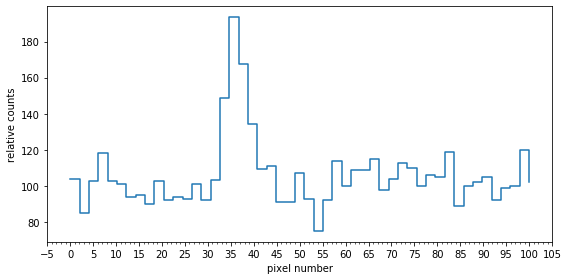

In [4]:
# simulate the star
x = np.linspace(0, 100)
mu = 35
S = 100
fwhm = 5
F = 500

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
sim_star = simulate(x, mu, fwhm, S, F)# complete
pixel_plot(x, sim_star, fig=fig, ax=ax)


In [7]:
# plot and inspect histogram

fig = plt.figure(figsize=(6,4))
# complete

S_estimate = 100 # complete

print('My background estimate = {:.4f}'.format(S_estimate))
print('The mean pixel count = {:.4f}'.format(np.mean(sim_star))) # complete

My background estimate = 100.0000
The mean pixel count = 105.9088


<Figure size 432x288 with 0 Axes>

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a2bc810>)

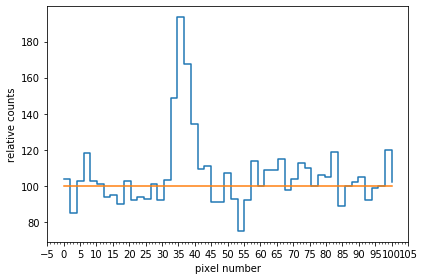

In [10]:
# plot your background model over the "image"

fig, ax = pixel_plot(x, sim_star)
pixel_plot(x, np.repeat(S_estimate,len(x)), fig=fig, ax=ax)

### Problem 1.2) Estimate a the background as a ramp/line (order = 1)

Now let's simulate a slightly more complicated background a linear ramp: $y = 3x + 100$. First simulate the same star with the new background. Then we're going to fit it using the following steps:
* Bin the image
* Use your robust estimator to estimate the background value per bin center
* Fit these bin center with a model

* A common simple model that astronomers use are Chebyshev polynomials. Chebyshevs have some very nice properties that prevent ringing at the edges of the fit window. Another popular way to "model" the bin centers is non-parametrically via interpolation.

In [ ]:
# Double check that your simulate function can take S optionally as array-like
## AC: Yeah, I think so!!!

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1a2bce10>)

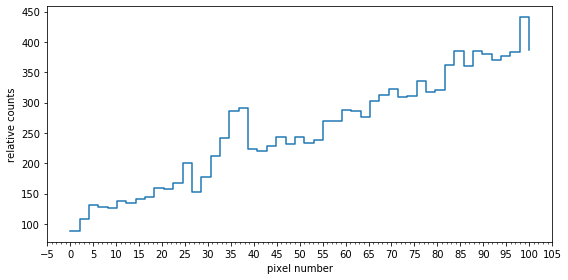

In [11]:
# Create and plot the image with S = 3*x + 100

x = np.linspace(0, 100)
mu = 35
S = 3*x + 100
fwhm = 5
F = 500

sim_star = simulate(x, mu, fwhm, S, F)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
pixel_plot(x, sim_star, fig=fig, ax=ax)

In [42]:
# bin the image in 20-pixel bins 

# complete
bin_centers = np.arange(0,100,20)+10 # complete
bin_values = [np.median(sim_star[((x > 0.97*i)&(x < 1.03*i))]) for i in bin_centers]# complete 

[137.0, 211.151309228309, 238.50000001800012, 316.5, 380.0]

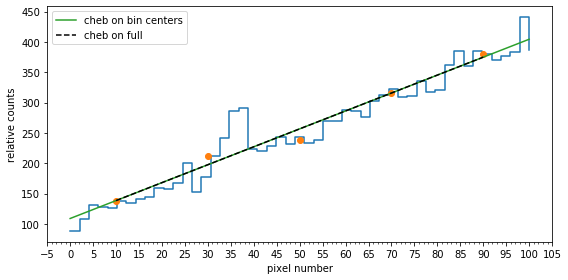

In [52]:
# Fit the bin_values vs bin_centers with a 1st-order chebyshev polynomial
# Evaluate your model for the full image
# hint: look up np.polynomial.chebyshev.chebfit and np.polynomial.chebyshev.chebeval

# complete

bg_model_chebfit = np.polynomial.chebyshev.chebfit(bin_centers,bin_values,1)
bg_model_eval = np.polynomial.chebyshev.chebval(bin_centers,bg_model_chebfit)
bg_model_eval_full = np.polynomial.chebyshev.chebval(x,bg_model_chebfit)

# Replot the image: 
fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
pixel_plot(x, sim_star, fig=fig, ax=ax)
# binned values
ax.plot(bin_centers, bin_values, 'o')

# Overplot your background model:
ax.plot(x, bg_model_eval_full, label='cheb on bin centers')
ax.plot(bin_centers, bg_model_eval, linestyle='--',color='black', label='cheb on full')
plt.legend()

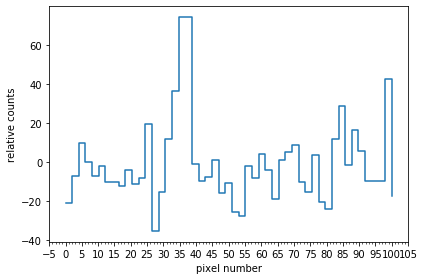

In [54]:
# Finally plot your background subtracted image:

fig, ax = pixel_plot(x, sim_star-bg_model_eval_full)

### Problem 1.3) Estimate a more realistic background (still in 1D)

Now repeat the the exercise in problem 1.2 with a more complex background. 

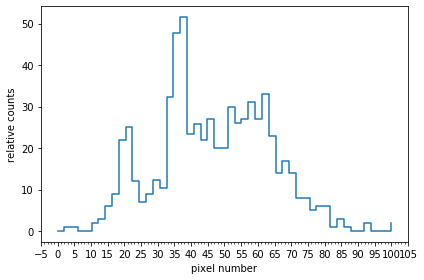

In [27]:
SIGMA_PER_FWHM = 2*np.sqrt(2*np.log(2))

fwhm = 5
x = np.linspace(0, 100)
background = 1000*norm.pdf(x, 50, 18) + 100*norm.pdf(x, 20, fwhm/SIGMA_PER_FWHM) + 100*norm.pdf(x, 60, fwhm/SIGMA_PER_FWHM)

sim_star3 = simulate(x=x, mu=35, fwhm=fwhm, S=background, F=200)
fig, ax = pixel_plot(x, sim_star3)

#### 1.3.1) Bin the image. Plot the bin centers. What bin size did you pick? 

In [109]:
bin_centers = np.arange(0,100,10)+2# complete
bin_values = [np.median(sim_star3[((x > 0.97*i)&(x < 1.03*i))]) for i in bin_centers]# complete 

[ 2 12 22 32 42 52 62 72 82 92] [1.0, 3.0, 12.00000093814638, 32.38003843307855, 23.919058855405222, 28.00000000000732, 28.0, 8.0, 3.0, 1.0124829133805354e-143]


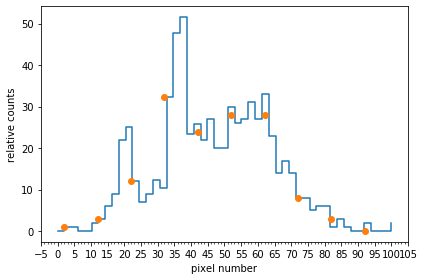

In [110]:
# overplot the binned esimtates:
fig, ax = pixel_plot(x, sim_star3)
ax.plot(bin_centers, bin_values, 'o')

print(bin_centers,bin_values)

#### 1.3.2) Spatially model the binned estimates (bin_values vs bin_centers) as a chebyshev polynomial.

Evaluate your model on the image grid and overplot.(what degree/order did you pick?)

Degree 7 looks best. Higher ones produce more dramatic tails nut similarly fit the data


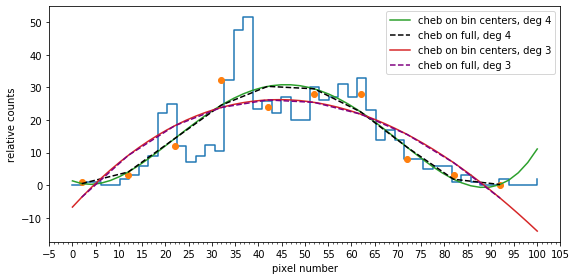

In [114]:
bg_model_chebfit = np.polynomial.chebyshev.chebfit(bin_centers,bin_values,4)
bg_model_eval = np.polynomial.chebyshev.chebval(bin_centers,bg_model_chebfit)
bg_model_eval_full = np.polynomial.chebyshev.chebval(x,bg_model_chebfit)

bg_model_chebfit3 = np.polynomial.chebyshev.chebfit(bin_centers,bin_values,3)
bg_model_eval3 = np.polynomial.chebyshev.chebval(bin_centers,bg_model_chebfit3)
bg_model_eval_full3 = np.polynomial.chebyshev.chebval(x,bg_model_chebfit3)

# Replot the image: 
fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
pixel_plot(x, sim_star3, fig=fig, ax=ax)
# binned values
ax.plot(bin_centers, bin_values, 'o')

# Overplot your background model:
ax.plot(x, bg_model_eval_full, label='cheb on bin centers, deg 4')
ax.plot(bin_centers, bg_model_eval, linestyle='--',color='black', label='cheb on full, deg 4')
ax.plot(x, bg_model_eval_full3, label='cheb on bin centers, deg 3')
ax.plot(bin_centers, bg_model_eval3, linestyle='--',color='purple', label='cheb on full, deg 3')
plt.legend()
print('Degree 7 looks best. Higher ones produce more dramatic tails nut similarly fit the data')

#### 1.3.3) Subtract off the model and plot the "background-subtracted image." 

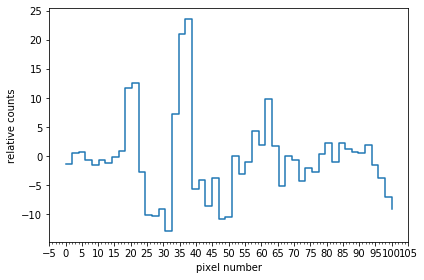

In [115]:
fig, ax = pixel_plot(x, sim_star3-bg_model_eval_full)

## Problem 2) Finding Sources

Now that we have subtracted background image,  let’s look for sources.  In the lecture we focused on the matched filter interpretation.  Here we will go into the hypothesis testing and maximum likelihood interpretations. 

### Maximum likelihood interpretation:

 Assume that we know there is a point source somewhere in this image.   We want to find  to pixel that has the maximum likelihood of having a point source centered on it.  recall from session 10, the probability for an  individual observation $I_i$ is:

$$P(X_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{-\frac{(X_i - y_i)^2}{2\sigma_i^2}}$$

Here: $X_i$ is the pixel value of pixel $i$ in the image and $y_i$ is the model prediction for that pixel. 

The model in this case is your `simulate()` function from the `IntroductionToBasicStellarPhotometry.ipynb` notebook: the PSF evaluated at a distance from the center multiplied by the flux amplitude: $F * \phi(x - x_{center}) + S$ Where $F$ is the flux amplitude $\phi$ is the PSF profile (a function of position), and $S$ is the background.

Plug it in:
$$P(X_i) = \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{-\frac{(X_i - (F * \phi_i(x_{center}) + S))^2}{2\sigma_i^2}}$$



### Hypothesis test interpretation:

If I were teaching source detection to my non-scientist, college stats 101 students, I'd frame the problem like this:

Pretend you have an infinitely large population of pixels Say I know definitively, that the arbitrarily large population of pixels is drawn from $N(0,100)$ (has a variance of 10). I have another sample of 13 pixels. I want to tesst the hypothesis that those 13 pixels were drawn from the $N(0,100)$ pop too. 

Test the hypothesis that your subsample of 13 pixels were drawn from the larger sample.
* $H_0$: $\mu = 0$
* $H_A$: $\mu > 0$

$$z = \frac{\bar{x} - \mu}{\sigma / \sqrt{n}} $$
$$z = \frac{\sum{x}/13 - 0}{10 /\sqrt{13}} $$

OK, if this is coming back now, let's replace this with our *real* estimator for PSF flux, which is a *weighted mean* of the pixels where the weights are the PSF $\phi_i$. Whenever I forget the formulas for weighted means, I consult the [wikipedia page](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean).

Now tweak it for a weighted mean (PSF flux):

$$ z = \frac{\sum{\phi_i x_i} - \mu} {\sqrt{ \sum{\phi_i^2 \sigma_i^2}}} $$

Where the denominator is from the variance estimate of a weighted mean.  For constant $\sigma$ it reduces to $\sigma_{\bar{x}}^2 = \sigma^2 \sum{\phi^2_i}$, and for a constant $\phi$ this reduces to $\sigma_{\bar{x}}^2 = \sigma^2 /n$, the denomiator in the simple mean example above. Replace $\mu=0$ again. 

$$ z = \frac{\sum{\phi_i x_i}} {\sqrt{ \sum{\phi_i^2 \sigma_i^2}}} $$
Our detection map is just the nominator for each pixel! We deal with the denominator later when choosing the thresholding, but we could just as easily divide the whole image by the denominator and have a z-score image!

### 2.0) Plot the problem image

(<Figure size 576x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a210c0350>)

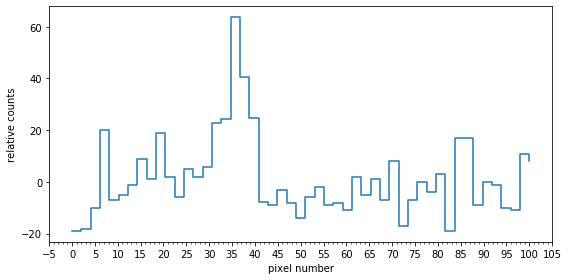

In [116]:
# set up simulation
x = np.linspace(0, 100)
mu = 35
S = 100
fwhm = 5
F = 300

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
sim_star = simulate(x, mu=mu, fwhm=fwhm, S=S, F=F)

# To simplify this pretend \sqrt{\sum \phi_i^2 \sigma_i^2we know for sure the background = 100
# Plots the backround subtracted image
image = sim_star - 100
pixel_plot(x, image, fig=fig, ax=ax)

### 2.1) Make a kernel for the PSF.

Properties of kernels: They're centered at x=0 (which also means that they have an odd number of pixels) and sum up to 1. You can use your `phi()`.

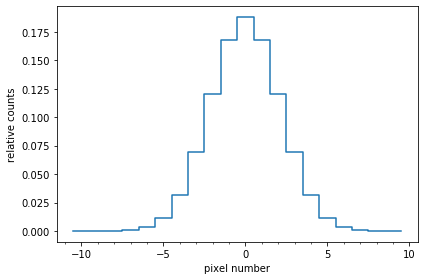

In [172]:
xx = np.arange(-10, 11) # complete
kernel = phi(xx, 0, 5)# complete  
# plot your kernel
pixel_plot(xx-0.5, kernel)
xx = xx-0.5

### 2.2) Correlate the image with the PSF kernel,

and plot the result.

What are the tradeoffs when choosing the size of your PSF kernel? What happens if its too big? What happens if it's too small.? 

**hint:** `scipy.signal.convolve`
**When it's too small (like 1, then it basically follows the noisiness of the data. If it's too big it's too smooth and it's hard to figure out the extent of the point source**

1.6266658952849076
-1.0938914318814763


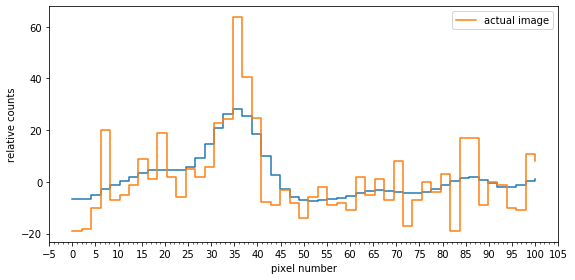

In [173]:
from scipy import signal
from scipy import stats

detection_image = signal.convolve(image,kernel,mode='same')# complete

# plot your detection image 
# Note: pay attention to how scipy.signal.convolve handles the edges. 

fig = plt.figure(figsize=(8,4))
ax = plt.subplot()
pixel_plot(x,detection_image, fig=fig, ax=ax)
ax.step(x, image, 
            where='post', label='actual image')
plt.legend()

print(np.mean(detection_image))
print(np.median(detection_image))

### 2.3) Detect pixels 

for which the null hypothesis that there's no source centered there is ruled out at the 5$\sigma$ level.

In [177]:
# Using a robust estimator for the detection image standard deviation,
# Compute the 5 sigma threshold

threshold_value = 3*np.std(detection_image)# complete
print('3 sigma threshold value is = {:.4f}'.format(threshold_value))

#changed this to 3 sigma because otherwise... I don't have a detection

3 sigma threshold value is = 26.4966


### 2.4) Dilate footprint to provide a window or region for the point source.
We will use this window to compute the centroid and total flux of the star in the next two lessons. In the meantime, compute the flux like we did in introductionToStellarPhotometry assuming the input center. 

In [180]:
signal_mu_idx = np.where(detection_image > threshold_value)
signal_mu = x[signal_mu_loc]

ap_radius = 5
diff = np.abs(x-signal_mu)
ap_mask = np.where(diff <= ap_radius)
ap_star = image[ap_mask]
print("The star has flux = {:.3f}".format(np.sum(ap_star)))

The star has flux = 176.154


## Challenge problem A

Combine problem 1 and 2 to iterate background estimation and source detection, masking the pixels with detections. Use the more complex background from 1.3. 

## Challenge problem B

Repeat challenge problem A in two dimensions